Importing and installing libraries

In [1]:
!pip install tensorflow-addons

In [12]:
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16,EfficientNetV2L,ResNet50,ResNet101
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt

Mounting drive

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Untar dataset on Colabs disk

In [5]:
#making direcrtories for dataset
!mkdir train_and_val_set
!mkdir test_set
# untar the dataset
!tar -xvf "/content/drive/MyDrive/train_and_val_set.tar" -C /content/train_and_val_set
!tar -xvf "/content/drive/MyDrive/test_set.tar" -C /content/test_set

Streaming output truncated to the last 5000 lines.
val_set/annotations/678_lnd.npy
val_set/annotations/1526_lnd.npy
val_set/annotations/5420_aro.npy
val_set/annotations/4628_exp.npy
val_set/annotations/5254_lnd.npy
val_set/annotations/4769_aro.npy
val_set/annotations/1994_lnd.npy
val_set/annotations/4840_lnd.npy
val_set/annotations/3546_val.npy
val_set/annotations/2606_lnd.npy
val_set/annotations/1282_val.npy
val_set/annotations/948_lnd.npy
val_set/annotations/2672_lnd.npy
val_set/annotations/1599_aro.npy
val_set/annotations/2177_exp.npy
val_set/annotations/1830_val.npy
val_set/annotations/4676_aro.npy
val_set/annotations/3228_aro.npy
val_set/annotations/5196_aro.npy
val_set/annotations/714_val.npy
val_set/annotations/2296_exp.npy
val_set/annotations/934_lnd.npy
val_set/annotations/1511_val.npy
val_set/annotations/2923_exp.npy
val_set/annotations/4198_aro.npy
val_set/annotations/886_lnd.npy
val_set/annotations/1924_exp.npy
val_set/annotations/1462_lnd.npy
val_set/annotations/812_exp.np

Loading Dataset

In [13]:
# number of training and testing examples
print(len(os.listdir('/content/train_and_val_set/train_set/images')))
print(len(os.listdir('/content/test_set/val_set/images')))

287651
3999


In [14]:
def load_and_read_train_data():
  train_annotations=[]
  train_images=[]
  i=0
  # final images csv contains name of images that will be part of a balanced dataset
  balanced_images = np.genfromtxt('final_images.csv', delimiter=',',dtype='<U16')
  for images in balanced_images:
        images=str(images)
        img_name=images[:-4]+'_'
        img=cv2.imread('/content/train_and_val_set/train_set/images/'+images)

        # downsampling images due to limited RAM
        img=cv2.resize(img,(100,100)) 
        train_images.append(img) 
        
        #making array of all annotation files of a same image
        ann=np.array([np.load('/content/train_and_val_set/train_set/annotations/'+img_name+'aro.npy'),np.load('/content/train_and_val_set/train_set/annotations/'+img_name+'lnd.npy'),np.load('/content/train_and_val_set/train_set/annotations/'+img_name+'val.npy'),np.load('/content/train_and_val_set/train_set/annotations/'+img_name+'exp.npy')])
        train_annotations.append(ann)
        if(i%2000==0):
          print(i)
        i+=1
  return train_images,train_annotations
def load_and_read_test_data():
  i=0
  val_annotations=[]
  val_images=[]

  # all test examples will be loaded
  for images in os.listdir('/content/test_set/val_set/images'):

        #print(images[:-4])
        img_name=images[:-4]+'_'
        img=cv2.imread('/content/test_set/val_set/images/'+images)

        # downsampling images due to limited RAM
        img=cv2.resize(img,(100,100))
        val_images.append(img) 

        #making array of all annotation files of a same image
        ann=np.array([np.load('/content/test_set/val_set/annotations/'+img_name+'aro.npy'),np.load('/content/test_set/val_set/annotations/'+img_name+'lnd.npy'),np.load('/content/test_set/val_set/annotations/'+img_name+'val.npy'),np.load('/content/test_set/val_set/annotations/'+img_name+'exp.npy')])
        val_annotations.append(ann) 
  return val_annotations,val_images

In [15]:
def dataset_spliting_and_preprocessing(train_images,train_annotations):

  
  # spliting data into 80% training examples and 20% validation examples
  X_train,  y_train,X_val, y_val = train_test_split(train_images, train_annotations, test_size=0.2, random_state=1,shuffle=True)
  
  X_train=np.asarray(X_train)
  y_train=np.asarray(y_train)
  X_val=np.asarray(X_val)
  y_val=np.asarray(y_val)
  # normalizing test and validation images
  X_train=X_train/255.0
  y_train=y_train/255.0

  # converting all list objects to numpy array 
  train_labels=np.asarray(X_val[:,3])
  train_val=np.asarray(X_val[:,2])
  train_aro=np.asarray(X_val[:,0])
  val_labels=np.asarray(y_val[:,3])
  val_val=np.asarray(y_val[:,2])
  val_aro=np.asarray(y_val[:,0])
  train_val = np.array([np.array(float(val)) for val in train_val])
  val_val = np.array([np.array(float(val)) for val in val_val])
  train_aro = np.array([np.array(float(val)) for val in train_aro])
  val_aro = np.array([np.array(float(val)) for val in val_aro])

  return X_train,train_labels,train_val,train_aro, y_train, val_labels, val_val,val_aro


In [16]:
def one_hot_encoding(train_labels,val_labels):

  # converting training labels and tes labels
    X_val = to_categorical(train_labels)
    y_val = to_categorical(val_labels)
    
    return X_val,y_val

In [17]:
def stem_network():

  # creating a input layer with input size 50x50
  image_input=tf.keras.Input(shape=(100,100,3))
  return image_input
def main_network(image_input):

  # using resnet 50 with pretrained weights
  baseline=(ResNet50(input_shape=(100,100,3),include_top=False,weights="imagenet",classes=8))(image_input)
  return baseline
def task_specific_head(baseline,image_input):

  # flattening the output of resnet50 in to a single tensor
  output=(tf.keras.layers.Flatten())(baseline)
  output=(tf.keras.layers.Dense(1024, activation="relu"))(output)
  output=(tf.keras.layers.Dropout(0.2))(output)
  output = tf.keras.layers.BatchNormalization()(output)
  output=(tf.keras.layers.Dense(1024, activation="relu"))(output)
  output=(tf.keras.layers.Dropout(0.2))(output)
  output = tf.keras.layers.BatchNormalization()(output)
  output=(tf.keras.layers.Dense(512, activation="relu"))(output)
  output = tf.keras.layers.BatchNormalization()(output)
  output=(tf.keras.layers.Dense(512, activation="relu"))(output)
  output = tf.keras.layers.BatchNormalization()(output)
  labels=(tf.keras.layers.Dense(8, activation=tf.keras.activations.softmax))(output)
  valence=(tf.keras.layers.Dense(1, activation="linear"))(labels)
  aro=(tf.keras.layers.Dense(1, activation="linear"))(labels)
  model=tf.keras.Model(inputs=image_input, outputs=[labels,valence,aro])
  return model

In [26]:
def model_creation():

  #initializing model
  image_input=stem_network()
  baseline=main_network(image_input)
  model=task_specific_head(baseline,image_input)

  # using adam optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=0.01)

  #compiling model
  # using categorical crossentropy loss for multi class classification
  #using mean square error for continuous domain
  model.compile(optimizer=opt, 
              loss=["categorical_crossentropy","mse","mse"],
              metrics=["accuracy","mse"])
  model.summary()
  return model

In [24]:
def train_model(model,X_train,X_val,train_val,train_aro,y_train,y_val,val_val,val_aro):

  # training the model with batch size of 32 for 30 epochs 
  history=model.fit(
      x=X_train,
      y=[X_val,train_val,train_aro],
      batch_size=32,
      epochs=15,
      verbose=1,
      validation_data=(y_train,[y_val,val_val,val_aro]))
  return history

Main


In [19]:
# loading training data
train_images,train_annotations=load_and_read_train_data()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000


In [20]:
X_train,train_labels,train_val,train_aro, y_train, val_labels, val_val,val_aro=dataset_spliting_and_preprocessing(train_images,train_annotations)
print(len(X_train))
print(len(train_labels))
print(len(y_train))
print(len(val_labels))

#displaying number of training examples for each class
print("0: ",np.sum(train_labels=='0'))
print("1: ",np.sum(train_labels=='1'))
print("2: ",np.sum(train_labels=='2'))
print("3: ",np.sum(train_labels=='3'))
print("4: ",np.sum(train_labels=='4'))
print("5: ",np.sum(train_labels=='5'))
print("6: ",np.sum(train_labels=='6'))
print("7: ",np.sum(train_labels=='7'))

34842
34842
8711
8711
0:  4779
1:  4861
2:  4814
3:  4803
4:  4816
5:  3017
6:  4772
7:  2980


In [21]:
#preparing labels
X_val,y_val=one_hot_encoding(train_labels,val_labels)

In [27]:
model=model_creation()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 4, 4, 2048)   23587712    ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 32768)        0           ['resnet50[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 1024)         33555456    ['flatten[0][0]']            

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#opt = SGD(lr=0.1,momentum=0.9)
model.compile(optimizer=opt, 
              loss=["categorical_crossentropy","mse","mse"],
              metrics=["accuracy","mse"])

In [25]:
history=train_model(model,X_train,X_val,train_val,train_aro,y_train,y_val,val_val,val_aro)

Epoch 1/15
1089/1089 [==============================] - 149s 122ms/step - loss: 1.2876 - dense_4_loss: 1.0907 - dense_5_loss: 0.1059 - dense_6_loss: 0.0909 - dense_4_accuracy: 0.6000 - dense_4_mse: 0.0661 - dense_5_accuracy: 0.0132 - dense_5_mse: 0.1059 - dense_6_accuracy: 0.0151 - dense_6_mse: 0.0909 - val_loss: 1656348.3750 - val_dense_4_loss: 1656348.2500 - val_dense_5_loss: 0.1485 - val_dense_6_loss: 0.1148 - val_dense_4_accuracy: 0.4872 - val_dense_4_mse: 0.0843 - val_dense_5_accuracy: 0.0134 - val_dense_5_mse: 0.1485 - val_dense_6_accuracy: 0.0149 - val_dense_6_mse: 0.1148
Epoch 2/15
1089/1089 [==============================] - 131s 120ms/step - loss: 1.2277 - dense_4_loss: 1.0397 - dense_5_loss: 0.1009 - dense_6_loss: 0.0871 - dense_4_accuracy: 0.6178 - dense_4_mse: 0.0635 - dense_5_accuracy: 0.0132 - dense_5_mse: 0.1009 - dense_6_accuracy: 0.0150 - dense_6_mse: 0.0871 - val_loss: 367134.7500 - val_dense_4_loss: 367134.6250 - val_dense_5_loss: 0.1524 - val_dense_6_loss: 0.1143 -

In [14]:
print(len(history.history))
for i in history.history:
  print(i)


20
loss
dense_4_loss
dense_5_loss
dense_6_loss
dense_4_accuracy
dense_4_mse
dense_5_accuracy
dense_5_mse
dense_6_accuracy
dense_6_mse
val_loss
val_dense_4_loss
val_dense_5_loss
val_dense_6_loss
val_dense_4_accuracy
val_dense_4_mse
val_dense_5_accuracy
val_dense_5_mse
val_dense_6_accuracy
val_dense_6_mse


Plots of first 30 epocs as in next 15 not much validation accuracy increased


Plot of accuracy of emotion labels

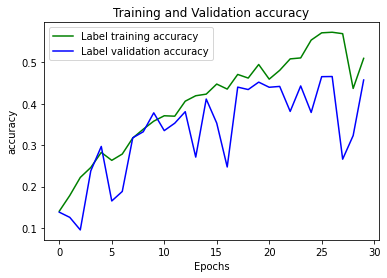

In [20]:
acc_train = history.history['dense_4_accuracy']
acc_val = history.history['val_dense_4_accuracy']
epochs = range(0,30)
plt.plot(epochs, acc_train, 'g', label='Label training accuracy')
plt.plot(epochs, acc_val, 'b', label='Label validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plotting loss of multiclass classification(emotion labels)


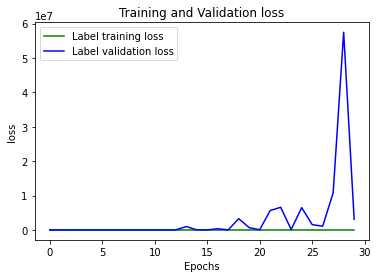

In [21]:
#plt.clear()
loss_train = history.history['dense_4_loss']
loss_val = history.history['val_dense_4_loss']
epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Label training loss')
plt.plot(epochs, loss_val, 'b', label='Label validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Plotting Mean Square Error of valence

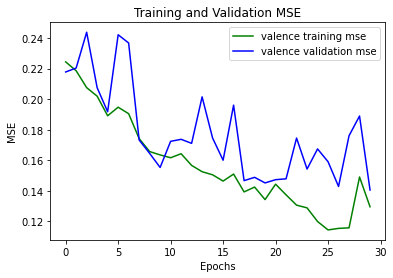

In [23]:
val_mse_train = history.history['dense_5_mse']
val_mse = history.history['val_dense_5_mse']
epochs = range(0,30)
plt.plot(epochs, val_mse_train, 'g', label='valence training mse')
plt.plot(epochs, val_mse, 'b', label='valence validation mse')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

Plotting mean square error of arousal


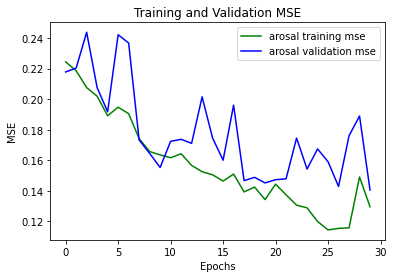

In [25]:
aro_mse_train = history.history['dense_6_mse']
aro_mse = history.history['val_dense_6_mse']
epochs = range(0,30)
plt.plot(epochs, val_mse_train, 'g', label='arosal training mse')
plt.plot(epochs, val_mse, 'b', label='arosal validation mse')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

Evaluation

In [26]:
def label_eval_mertics(pred_labels,test_labels):

  # undoing one hot encoding 
  results=np.argmax(pred_labels,axis=1)
  actual_values=np.argmax(test_labels,axis=1)

  # counting correctly and misclassified test examples
  T=0
  F=0
  for i in range(0,len(results)):
    if(results[i]==actual_values[i]):
      T+=1
    else:
      F+=1
  # calculating accuracy
  print("Accuracy: ",T/(T+F))

  # calculating f1 score
  f1score=tfa.metrics.F1Score(num_classes=8, threshold=0.5)
  f1score.update_state(pred_labels, test_labels)
  print("f1 score: ",f1score.result())


  # calculating cohens kappa
  kappa=tfa.metrics.CohenKappa(num_classes=8)
  kappa.update_state(pred_labels, test_labels)
  print("kappa: ",kappa.result())

  
  # calculating area under the ROC curve
  AUC=tf.keras.metrics.AUC(curve='ROC')
  AUC.update_state(pred_labels, test_labels)
  print("AUC: ",AUC.result())

  # calculating area under the Precision recall  curve
  AUC_PR=tf.keras.metrics.AUC(curve='PR')
  AUC_PR.update_state(pred_labels, test_labels)
  print("AUC PR: ",AUC_PR.result())
def continuous_eval_metrics(pred,test):

  #Calculating Root mean square
  rms=tf.keras.metrics.RootMeanSquaredError()
  rms.update_state(pred, test)
  print("Root mean squared error: ",rms.result())

  #Calculating Correlation
  pred_cov=pred.reshape((pred.shape[0],))
  print("correlation: ",np.corrcoef(pred_cov,test)[0,1])
  
  #calculating CCC (concordance,correlation,coefficient)
  sxy = np.sum((pred_cov - pred_cov.mean())*(test - test.mean()))/pred_cov.shape[0]
  rhoc = 2*sxy / (np.var(pred_cov) + np.var(test) + (pred_cov.mean() - test.mean())**2)
  print("CCC: ", rhoc)


In [24]:
def test_model(model):

  #loading test data
  test_annotations,test_images=load_and_read_test_data()

  #preprocessing test data
  test_images=np.asarray(test_images)
  test_annotations=np.asarray(test_annotations)
  test_labels=np.asarray(test_annotations[:,3])
  test_aro=np.asarray(test_annotations[:,0])
  test_val=np.asarray(test_annotations[:,2])
  test_val = np.array([np.array(float(val)) for val in test_val])
  test_aro = np.array([np.array(float(val)) for val in test_aro])

  #normalizing test images
  test_images=test_images/255.0

  # performing one hot encoding
  test_labels = to_categorical(test_labels)

  # predicting labels,valence and arousal on test data
  pred_labels,pre_valence,pred_aro=model.predict(test_images)

  # evaluation
  print()
  print()
  print("             QUANTITATIVE RESULTS")
  print()
  print()
  print("#######################################################")
  print("                    Emotion labels ")
  print("#######################################################")
  label_eval_mertics(pred_labels,test_labels)
  print("#######################################################")
  print("                        Valence")
  print("#######################################################")
  continuous_eval_metrics(pre_valence,test_val)
  print("#######################################################")
  print("                        Arousal")
  print("#######################################################")
  continuous_eval_metrics(pred_aro,test_aro)
  print()
  print()
  print("             QUALITATIVE RESULTS")
  print()
  print()
  correct=[]
  wrong=[]
  results=np.argmax(pred_labels,axis=1)
  actual_values=np.argmax(test_labels,axis=1)
  for i in range(0,len(results)):
    if(results[i]==actual_values[i]):
      correct.append(test_images[i])
    else:
      wrong.append(test_images[i])
  print("#######################################################")
  print("             Correctly Classified: ")
  print("#######################################################")
  for i in range(0,10):
    cv2_imshow(correct[i]*255)
  print("#######################################################")
  print("                   MisClassified: ")
  print("#######################################################")
  for i in range(0,10):
    cv2_imshow(wrong[i]*255)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.




             QUANTITATIVE RESULTS


#######################################################
                    Emotion labels 
#######################################################
Accuracy:  0.4946134033508377
f1 score:  tf.Tensor(
[0.31285778 0.5925848  0.3751613  0.40547052 0.47091013 0.37366468
 0.38662696 0.37149158], shape=(8,), dtype=float32)
kappa:  tf.Tensor(0.37555492, shape=(), dtype=float32)
AUC:  tf.Tensor(0.5150689, shape=(), dtype=float32)
AUC PR:  tf.Tensor(0.9884112, shape=(), dtype=float32)
#######################################################
                        Valence
#######################################################
Root mean squared error:  tf.Tensor(0.41858503, shape=(), dtype=float32)
correlation:  0.5256880583711568
CCC:  0.5143899487783554
#######################################################
                        Arousal
#######################################################
Root mean squared error:  tf.Tensor(0.36485124, shape=(), dtyp

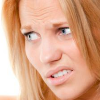

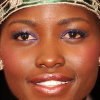

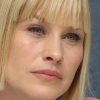

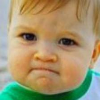

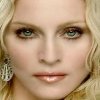

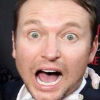

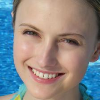

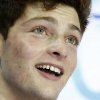

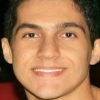

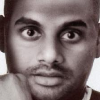

#######################################################
                   MisClassified: 
#######################################################


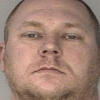

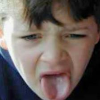

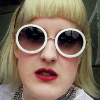

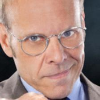

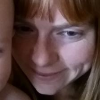

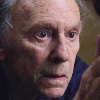

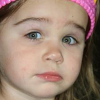

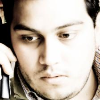

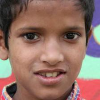

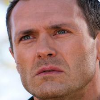

In [25]:
test_model(model)